# Reproducing Hakim CDA Study (2019) - Cleaning

In [1]:
import numpy as np
import glob
import pickle

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_brainvision

from scipy.io import loadmat

from autoreject import AutoReject

import os
import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Hakim-2019/')
from events import get_specific_events, get_epochs, get_CDA, prep_report, fill_report, get_report, checksum

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Prep Data

In [2]:
#==================================================================
# General Variables
#==================================================================
# Organize Triggers
triggers = dict();

# --------------------------
triggers['2'] = [2, 3]
triggers['4'] = [4, 5]

triggers['left'] = [3, 5]   #[2, 4]
triggers['right'] = [2, 4]  #[3, 5]

triggers['good'] = [91]
triggers['bad'] = [90]

# Labels
conds = ['2', '4']
sides = ['left', 'right']
perfs = ['good', 'bad']

# CDA Channels
chan_right = ['O2', 'PO4', 'PO8', 'P4', 'P8']
chan_left = ['O1', 'PO3', 'PO7', 'P3', 'P7']
#chan_right = ['PO8']
#chan_left = ['PO7']

# Epoch Information
epoch_length = 1.4
epoch_tmin = -0.4
baseline_corr = (-0.4, 0)

# CDA main variable!
cda_dict = dict()
cda_dict_clean = dict()
report = prep_report(conds, sides, perfs)


#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
experiences = ['Exp1a', 'Exp1b', 'Exp2a', 'Exp2b'] 

eegfiles = []
for cur_exp in experiences:
    folderpath = '/Volumes/Nick - Data/CDA Datasets/Hakim 2019/{}/EEGData/**/*.vhdr'.format(cur_exp)
    for filepath in glob.glob(folderpath, recursive=True):
        eegfiles.append(filepath)

for filepath in eegfiles:
    filename = filepath[filepath.rfind('/')+1:]
    print('Processing: ' + filename + '...')

    # ------------------------
    # 1. -- Load File --
    # ------------------------
    raw = read_raw_brainvision(filepath, preload=True)
        
    # ------------------------
    # 2. -- Preprocessing --
    # ------------------------
    preproc = raw

    # Filter
    preproc = preproc.filter(.1, 30., fir_design='firwin')

    # Get events
    events = mne.events_from_annotations(preproc)
    events = events[0]
    
    #preproc.plot(events=events[0], block=True, lowpass=40)

    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    specific_events = get_specific_events(events, conds, sides, perfs, triggers)

    epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

    # ------------------------
    # X. -- CLEANING! --
    # ------------------------
    ar = AutoReject()

    # Flatten epochs to clean all at once.
    epochs_dict_clean = dict()
    epochs_to_clean = []
    for c in epochs_dict.keys():
        epochs_dict_clean[c] = dict()
        for s in epochs_dict[c].keys():
            epochs_dict_clean[c][s] = dict()
            for p in ['good']:#epochs_dict[c][s].keys():
                epochs_dict_clean[c][s][p] = []
                epochs_to_clean.append(epochs_dict[c][s][p])

    len(epochs_to_clean)

    cleaned_epochs = ar.fit_transform(mne.concatenate_epochs(epochs_to_clean)) 

    # Reconstruct epochs                
    for cond in conds:
        for t in triggers[cond]:
            for side in sides:
                if t in triggers[side]:
                    cur_side = side

            epochs_dict_clean[cond][cur_side]['good'].append(cleaned_epochs[str(t)])

    # Concatenate Epochs into Epochs MNE structure (from a list of Epochs because of diff triggers)
    for cond in conds:
        for side in sides:
            epochs_dict_clean[cond][side]['good'] = mne.concatenate_epochs(epochs_dict_clean[cond][side]['good'])
            
    # ------------------------
    # 4. - Report & Checksum -
    # ------------------------
    report = fill_report(report, filename, specific_events)
    report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict_clean)
    
    # ------------------------
    # 5. -- CDA --
    # ------------------------
    cda_dict[filename] = get_CDA(epochs_dict, conds, sides, perfs, chan_right, chan_left)
    cda_dict_clean[filename] = get_CDA(epochs_dict_clean, conds, sides, ['good'], chan_right, chan_left)

# Add time points to CDA for later use.
times = epochs_dict['2']['left']['good'].times

print('{} Subjects & {} Trials'.format(len(report), np.sum([report[cond].sum() for cond in conds])))
report

Processing: 10_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/10/10_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 5127809  =      0.000 ... 10255.618 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
154 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 154 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
46 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 46 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.40 and n_interpolate=1



Dropped 6 epochs: 42, 249, 281, 464, 535, 539
Not setting metadata
Not setting metadata
153 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
161 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
126 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
125 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (154 events vs 153 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (163 events vs 161 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! Length mismatch for: 4-right-good (128 events vs 125 epochs)
Checksum FAILED! In

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.50 and n_interpolate=1



Dropped 24 epochs: 26, 30, 53, 104, 145, 153, 159, 165, 199, 228, 234, 282, 291, 321, 336, 341, 424, 467, 493, 627, 629, 634, 639, 649
Not setting metadata
Not setting metadata
182 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
173 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
137 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
149 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (190 events vs 182 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (181 events vs 173 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (14

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.20 and n_interpolate=4



Dropped 220 epochs: 2, 4, 7, 8, 11, 21, 28, 29, 30, 31, 36, 40, 42, 44, 48, 51, 58, 59, 64, 71, 72, 74, 75, 76, 79, 80, 81, 82, 88, 90, 91, 94, 95, 96, 97, 99, 100, 101, 105, 106, 108, 109, 110, 111, 113, 115, 118, 119, 120, 121, 122, 125, 126, 129, 130, 131, 132, 133, 134, 136, 137, 142, 146, 147, 148, 155, 158, 159, 160, 161, 163, 165, 166, 167, 169, 170, 171, 174, 175, 176, 177, 179, 180, 181, 183, 187, 191, 195, 199, 200, 202, 204, 209, 211, 218, 219, 220, 222, 226, 228, 230, 235, 238, 241, 244, 247, 249, 252, 253, 254, 257, 259, 260, 261, 262, 263, 264, 269, 273, 274, 281, 282, 283, 284, 285, 286, 292, 296, 300, 301, 306, 309, 312, 316, 318, 322, 323, 327, 330, 331, 332, 333, 335, 336, 337, 339, 340, 341, 346, 347, 350, 354, 355, 357, 360, 361, 362, 363, 364, 365, 367, 368, 371, 372, 374, 375, 376, 377, 378, 405, 409, 414, 426, 429, 434, 436, 437, 439, 444, 453, 466, 469, 477, 482, 495, 505, 507, 512, 520, 526, 531, 533, 538, 543, 551, 552, 558, 559, 585, 596, 603, 605, 608, 614,

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.60 and n_interpolate=4



Dropped 22 epochs: 5, 9, 132, 134, 138, 139, 148, 169, 176, 178, 181, 182, 302, 320, 329, 353, 379, 415, 482, 491, 517, 591
Not setting metadata
Not setting metadata
162 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
171 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
132 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
133 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (169 events vs 162 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (179 events vs 171 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (136 events vs

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.80 and n_interpolate=4



Dropped 3 epochs: 150, 375, 452
Not setting metadata
Not setting metadata
140 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
127 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
112 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
102 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (128 events vs 127 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (113 events vs 112 epochs)
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! Length mismatch for: 4-right-good (103 events vs 102 epochs)
Checksum FAILED! Invalid key for:

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
184 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 184 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=0.40 and n_interpolate=1



Dropped 67 epochs: 5, 21, 22, 37, 40, 66, 72, 78, 101, 103, 105, 161, 195, 222, 227, 239, 262, 265, 271, 272, 277, 291, 342, 345, 364, 365, 370, 373, 393, 400, 411, 434, 444, 448, 452, 461, 465, 467, 468, 469, 487, 489, 493, 496, 497, 506, 509, 514, 521, 527, 529, 530, 546, 548, 562, 570, 583, 598, 617, 630, 632, 642, 670, 676, 685, 691, 694
Not setting metadata
Not setting metadata
172 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
179 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
137 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
149 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (184 events vs 172 epochs)
Checksum FAIL

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
149 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 149 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 51 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.60 and n_interpolate=1



Dropped 10 epochs: 15, 27, 108, 243, 262, 303, 404, 432, 474, 478
Not setting metadata
Not setting metadata
146 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
162 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
113 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
116 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (149 events vs 146 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (165 events vs 162 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (114 events vs 113 epochs)
Checksum FAILED! Invalid key for: 4-left-bad


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
183 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 183 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
17 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 17 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.70 and n_interpolate=4



Dropped 5 epochs: 332, 460, 534, 547, 643
Not setting metadata
Not setting metadata
183 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
189 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
162 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
153 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (190 events vs 189 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (164 events vs 162 epochs)
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! Length mismatch for: 4-right-good (155 events vs 153 epochs)
Checksum FAILED! Invali

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.50 and n_interpolate=1



Dropped 14 epochs: 39, 64, 121, 173, 184, 266, 337, 369, 378, 450, 463, 584, 612, 685
Not setting metadata
Not setting metadata
189 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
189 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
157 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
147 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (194 events vs 189 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (193 events vs 189 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (159 events vs 157 epochs)
Checksum FAILED! Invalid 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
195 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 195 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 5 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadat







Estimated consensus=0.50 and n_interpolate=4



Dropped 9 epochs: 76, 98, 163, 186, 345, 375, 376, 380, 525
Not setting metadata
Not setting metadata
191 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
188 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
157 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (195 events vs 191 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (192 events vs 188 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (153 events vs 152 epochs)
Checksum FAILED! Invalid key for: 4-left-bad
Checks

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
147 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 147 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
53 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 53 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.20 and n_interpolate=4



Dropped 99 epochs: 5, 21, 26, 32, 33, 34, 35, 36, 38, 39, 42, 47, 55, 65, 74, 103, 114, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 136, 141, 145, 146, 148, 151, 153, 165, 173, 181, 183, 184, 185, 186, 187, 190, 239, 247, 256, 264, 276, 277, 278, 279, 280, 281, 322, 332, 336, 338, 339, 340, 341, 342, 343, 344, 348, 351, 354, 367, 376, 386, 390, 401, 409, 414, 415, 416, 418, 429, 430, 440, 453, 454, 455, 456, 457, 458, 486, 488, 489, 505, 521, 530, 532, 535, 536, 537, 551, 553, 557, 561
Not setting metadata
Not setting metadata
116 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
142 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
98 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
108 matching events found
Applying baseline correction (mode: mean)


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
153 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 153 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
47 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 47 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.40 and n_interpolate=1



Dropped 28 epochs: 26, 97, 103, 117, 118, 129, 133, 137, 151, 152, 218, 223, 245, 251, 271, 280, 289, 359, 405, 409, 438, 442, 451, 495, 497, 507, 525, 531
Not setting metadata
Not setting metadata
143 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
142 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
133 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
114 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (153 events vs 143 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (149 events vs 142 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=0.30 and n_interpolate=4



Dropped 89 epochs: 2, 25, 53, 56, 58, 65, 70, 78, 82, 86, 100, 103, 111, 113, 116, 119, 120, 124, 128, 131, 133, 137, 162, 192, 195, 200, 202, 208, 215, 216, 217, 223, 224, 225, 227, 238, 243, 249, 255, 256, 258, 261, 263, 264, 266, 267, 270, 271, 272, 273, 274, 276, 283, 295, 300, 322, 324, 325, 327, 345, 372, 373, 379, 382, 383, 391, 394, 395, 398, 399, 402, 410, 419, 432, 433, 435, 439, 440, 464, 485, 489, 491, 493, 494, 495, 497, 504, 505, 506
Not setting metadata
Not setting metadata
121 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
113 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
96 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
92 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (event

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.40 and n_interpolate=4



Dropped 27 epochs: 0, 7, 21, 33, 50, 99, 143, 157, 166, 217, 218, 256, 335, 374, 387, 392, 396, 397, 400, 426, 431, 443, 496, 497, 536, 550, 619
Not setting metadata
Not setting metadata
176 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
183 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
132 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
151 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (185 events vs 176 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (187 events vs 183 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-lef

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 150 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 50 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=1.00 and n_interpolate=4



Dropped 3 epochs: 88, 449, 543
Not setting metadata
Not setting metadata
149 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
165 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
117 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
127 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (150 events vs 149 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! Length mismatch for: 4-right-good (129 events vs 127 epochs)
Checksum FAILED! Invalid key for: 4-right-bad
Processing: 29_WM_att_NHKA.vhdr...
Extracting parameters from /Vol

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.80 and n_interpolate=4



Dropped 1 epoch: 436
Not setting metadata
Not setting metadata
191 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
186 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
159 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (160 events vs 159 epochs)
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! Invalid key for: 4-right-bad
Processing: 31_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/31/31_WM_att_NHKA.vhdr...
Setting

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=0.10 and n_interpolate=1



Dropped 226 epochs: 0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 26, 33, 42, 52, 55, 62, 65, 66, 67, 76, 79, 82, 84, 85, 86, 87, 88, 103, 107, 110, 114, 116, 118, 120, 121, 123, 124, 126, 127, 128, 131, 135, 140, 141, 146, 148, 149, 150, 151, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 173, 176, 177, 180, 197, 205, 207, 208, 212, 219, 224, 231, 234, 238, 239, 240, 241, 242, 243, 246, 247, 251, 253, 260, 261, 263, 265, 267, 273, 276, 277, 281, 284, 287, 297, 299, 300, 301, 302, 304, 305, 306, 310, 314, 315, 316, 318, 320, 321, 323, 324, 327, 330, 334, 335, 336, 337, 338, 339, 340, 341, 343, 344, 345, 346, 348, 349, 351, 354, 355, 358, 365, 366, 367, 375, 381, 383, 386, 388, 389, 390, 393, 396, 398, 407, 408, 409, 410, 411, 412, 414, 419, 420, 425, 428, 431, 433, 436, 437, 438, 441, 442, 446, 447, 448, 450, 452, 455, 456, 457, 464, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 478, 479, 512, 516, 518, 519, 521, 525, 526, 528, 529, 533, 534,

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
191 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 191 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadat







Estimated consensus=0.40 and n_interpolate=4



Dropped 61 epochs: 1, 6, 9, 29, 48, 57, 58, 59, 71, 90, 101, 113, 118, 120, 122, 126, 135, 137, 148, 151, 155, 172, 196, 198, 204, 209, 281, 315, 320, 327, 330, 332, 335, 352, 376, 383, 387, 388, 424, 425, 449, 485, 487, 528, 529, 544, 546, 553, 557, 569, 570, 579, 580, 593, 608, 615, 624, 645, 647, 654, 655
Not setting metadata
Not setting metadata
169 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
176 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
133 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
124 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (191 events vs 169 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Ch

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
197 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 197 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadat







Estimated consensus=0.20 and n_interpolate=1



Dropped 142 epochs: 13, 18, 19, 21, 24, 29, 30, 31, 36, 37, 39, 40, 46, 47, 48, 51, 52, 59, 63, 65, 66, 70, 71, 72, 74, 75, 81, 84, 85, 91, 92, 93, 94, 96, 98, 102, 103, 107, 114, 119, 122, 130, 145, 171, 189, 204, 213, 214, 219, 231, 232, 233, 235, 236, 244, 245, 262, 263, 264, 267, 268, 269, 271, 276, 282, 283, 284, 285, 298, 299, 300, 301, 305, 320, 323, 342, 352, 359, 374, 399, 404, 409, 413, 420, 422, 427, 428, 432, 437, 439, 440, 442, 447, 451, 453, 454, 458, 468, 469, 470, 471, 483, 484, 500, 543, 586, 588, 589, 590, 592, 594, 595, 597, 600, 601, 602, 605, 606, 612, 614, 616, 626, 627, 628, 630, 631, 632, 633, 634, 638, 639, 642, 646, 649, 651, 652, 657, 660, 663, 670, 683, 691
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
161 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
1

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
153 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 153 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
47 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 47 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=0.40 and n_interpolate=4



Dropped 68 epochs: 0, 37, 53, 63, 73, 82, 83, 85, 96, 111, 112, 117, 119, 122, 124, 128, 134, 155, 159, 167, 171, 184, 197, 200, 201, 208, 212, 218, 250, 258, 260, 261, 263, 271, 277, 296, 337, 343, 347, 352, 354, 357, 363, 367, 384, 390, 396, 400, 403, 423, 428, 457, 460, 462, 467, 478, 481, 486, 490, 492, 493, 501, 506, 517, 523, 530, 542, 548
Not setting metadata
Not setting metadata
136 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
139 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
109 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
108 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (153 events vs 136 epochs)
Checksum 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
191 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 191 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadat







Estimated consensus=1.00 and n_interpolate=30



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
191 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
190 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
153 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! Invalid key for: 4-right-bad
Processing: 39_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/39/39_W

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
186 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 186 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.30 and n_interpolate=4



Dropped 72 epochs: 89, 94, 97, 114, 121, 123, 126, 131, 132, 143, 156, 163, 165, 166, 167, 186, 242, 251, 254, 268, 270, 277, 286, 290, 294, 295, 296, 297, 306, 308, 311, 314, 334, 337, 342, 343, 344, 346, 352, 378, 403, 411, 413, 426, 440, 476, 478, 485, 491, 492, 498, 515, 550, 556, 568, 578, 581, 587, 588, 591, 592, 595, 600, 603, 607, 614, 624, 640, 641, 642, 643, 644
Not setting metadata
Not setting metadata
171 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
136 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
131 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (186 even

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
184 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 184 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.30 and n_interpolate=1



Dropped 83 epochs: 7, 10, 17, 31, 49, 55, 56, 59, 75, 77, 78, 106, 107, 111, 113, 121, 122, 123, 125, 129, 135, 136, 142, 162, 191, 210, 215, 234, 244, 261, 270, 274, 276, 278, 284, 285, 289, 290, 299, 303, 314, 333, 348, 371, 383, 388, 403, 422, 424, 434, 441, 460, 462, 472, 474, 487, 488, 493, 511, 512, 516, 523, 529, 536, 548, 550, 551, 554, 556, 557, 558, 561, 566, 569, 571, 572, 575, 580, 585, 599, 611, 613, 616
Not setting metadata
Not setting metadata
160 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
119 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
110 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAIL

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
182 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 182 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 18 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.70 and n_interpolate=4



Dropped 2 epochs: 150, 201
Not setting metadata
Not setting metadata
181 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
174 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
140 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
130 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (182 events vs 181 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (175 events vs 174 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! Invalid key for: 4-right-bad
Processing: 5_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.80 and n_interpolate=4



Dropped 1 epoch: 537
Not setting metadata
Not setting metadata
196 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
196 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
157 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
157 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (158 events vs 157 epochs)
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! Invalid key for: 4-right-bad
Processing: 6_WM_att_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1a/EEGData/6/6_WM_att_NHKA.vhdr...
Setting ch

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
149 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 149 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 51 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.50 and n_interpolate=4



Dropped 15 epochs: 10, 34, 81, 96, 138, 163, 194, 306, 313, 335, 344, 372, 432, 529, 547
Not setting metadata
Not setting metadata
144 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
153 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
118 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
118 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (149 events vs 144 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (155 events vs 153 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (123 events vs 118 epochs)
Checksum FAILED! Inval

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
188 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 188 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.30 and n_interpolate=1



Dropped 197 epochs: 18, 19, 28, 29, 32, 33, 34, 36, 39, 42, 44, 45, 47, 51, 53, 57, 58, 59, 60, 64, 65, 67, 69, 71, 74, 77, 81, 85, 86, 89, 90, 91, 94, 95, 96, 101, 102, 105, 106, 108, 110, 113, 116, 118, 122, 126, 130, 133, 141, 144, 149, 152, 153, 158, 161, 164, 167, 169, 179, 184, 190, 191, 194, 196, 221, 231, 232, 233, 235, 238, 239, 244, 245, 246, 257, 258, 264, 265, 266, 269, 272, 273, 275, 278, 280, 285, 286, 288, 294, 295, 297, 298, 302, 307, 308, 309, 311, 313, 318, 331, 343, 347, 348, 351, 354, 355, 356, 361, 366, 372, 376, 377, 378, 379, 380, 395, 410, 413, 415, 416, 419, 421, 423, 424, 426, 429, 430, 433, 434, 436, 437, 443, 444, 446, 447, 448, 449, 454, 459, 464, 465, 467, 468, 479, 482, 484, 487, 490, 491, 496, 498, 500, 503, 505, 509, 511, 512, 514, 515, 518, 521, 522, 526, 538, 548, 549, 550, 551, 553, 573, 579, 583, 584, 597, 599, 603, 607, 609, 616, 618, 623, 626, 627, 628, 630, 632, 635, 637, 638, 643, 661, 669, 670, 674, 679, 685, 687
Not setting metadata
Not setti

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
191 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 191 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadat







Estimated consensus=0.60 and n_interpolate=1



Dropped 21 epochs: 19, 31, 148, 154, 162, 188, 203, 207, 323, 356, 359, 388, 399, 424, 431, 436, 486, 509, 522, 596, 705
Not setting metadata
Not setting metadata
185 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
186 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
167 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (191 events vs 185 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (191 events vs 186 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (158 events vs 15

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
161 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 161 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
39 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 39 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.70 and n_interpolate=4



Dropped 35 epochs: 22, 48, 81, 93, 95, 98, 121, 135, 141, 232, 265, 266, 267, 281, 310, 315, 338, 365, 394, 409, 412, 417, 420, 427, 453, 454, 465, 490, 491, 535, 542, 561, 582, 584, 600
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
173 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
117 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
129 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (161 events vs 152 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (181 events vs 173 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
C

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
194 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 194 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 6 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadat







Estimated consensus=0.20 and n_interpolate=4



Dropped 88 epochs: 31, 37, 45, 48, 69, 70, 80, 82, 83, 96, 97, 101, 107, 119, 120, 131, 133, 134, 169, 180, 188, 189, 191, 193, 200, 212, 233, 237, 240, 255, 258, 263, 269, 272, 273, 287, 298, 299, 300, 306, 307, 321, 333, 339, 346, 365, 376, 381, 383, 385, 390, 394, 417, 441, 447, 461, 482, 490, 497, 505, 515, 521, 522, 527, 531, 532, 536, 543, 547, 551, 554, 556, 559, 568, 571, 597, 609, 615, 624, 632, 647, 672, 674, 699, 708, 713, 714, 717
Not setting metadata
Not setting metadata
170 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
168 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
146 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
146 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events v

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
184 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 184 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.50 and n_interpolate=1



Dropped 24 epochs: 26, 100, 152, 163, 181, 203, 207, 221, 226, 267, 280, 353, 407, 423, 436, 451, 453, 468, 469, 486, 543, 562, 601, 619
Not setting metadata
Not setting metadata
179 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
170 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
133 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
133 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (184 events vs 179 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (177 events vs 170 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
149 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 149 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 51 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.70 and n_interpolate=4



Dropped 9 epochs: 16, 43, 87, 176, 304, 405, 430, 432, 517
Not setting metadata
Not setting metadata
146 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
125 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
124 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (149 events vs 146 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (151 events vs 150 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (127 events vs 125 epochs)
Checksum FAILED! Invalid key for: 4-left-bad
Checksu

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
106 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 106 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
94 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 94 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.40 and n_interpolate=1



Dropped 16 epochs: 12, 62, 89, 107, 130, 143, 158, 205, 218, 231, 236, 249, 317, 327, 379, 425
Not setting metadata
Not setting metadata
103 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
102 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
108 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
98 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (106 events vs 103 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (107 events vs 102 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (113 events vs 108 epochs)
Checksum FAILED! 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.40 and n_interpolate=1



Dropped 28 epochs: 55, 90, 95, 103, 105, 107, 122, 153, 156, 168, 169, 185, 190, 196, 230, 258, 262, 276, 321, 335, 387, 408, 410, 447, 512, 535, 538, 549
Not setting metadata
Not setting metadata
156 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
156 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
114 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (165 events vs 156 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (166 events vs 156 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 180 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.20 and n_interpolate=1



Dropped 108 epochs: 9, 10, 11, 14, 15, 16, 18, 19, 20, 22, 24, 34, 39, 46, 49, 50, 51, 55, 58, 96, 97, 124, 135, 141, 153, 154, 156, 158, 160, 167, 177, 178, 182, 183, 191, 195, 196, 197, 204, 207, 208, 231, 249, 250, 257, 268, 269, 272, 273, 274, 289, 304, 315, 334, 337, 338, 342, 350, 351, 364, 366, 367, 376, 377, 379, 380, 397, 399, 418, 420, 440, 442, 443, 465, 469, 481, 483, 485, 494, 496, 504, 505, 510, 511, 512, 514, 515, 517, 518, 523, 524, 534, 543, 547, 548, 549, 591, 599, 606, 607, 610, 617, 619, 621, 622, 627, 631, 642
Not setting metadata
Not setting metadata
148 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
159 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
118 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
110 matching events found
A

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
198 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 198 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadat







Estimated consensus=0.50 and n_interpolate=4



Dropped 5 epochs: 165, 215, 311, 488, 605
Not setting metadata
Not setting metadata
197 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
194 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
181 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
174 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (198 events vs 197 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (196 events vs 194 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (182 events vs 181 epochs)
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! Length 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
159 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 159 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
41 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 41 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.20 and n_interpolate=1



Dropped 104 epochs: 4, 12, 19, 26, 38, 42, 47, 48, 55, 56, 58, 60, 64, 85, 88, 89, 91, 93, 97, 112, 114, 119, 125, 126, 132, 133, 148, 159, 169, 183, 190, 192, 193, 195, 200, 201, 212, 213, 220, 221, 226, 230, 242, 252, 253, 258, 259, 260, 265, 268, 273, 277, 278, 279, 280, 282, 283, 300, 303, 310, 311, 315, 328, 350, 353, 355, 357, 358, 359, 360, 368, 379, 397, 401, 403, 404, 422, 423, 468, 469, 478, 483, 494, 496, 500, 502, 503, 511, 512, 515, 526, 527, 532, 535, 536, 541, 542, 551, 552, 555, 556, 561, 562, 563
Not setting metadata
Not setting metadata
132 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
101 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
107 matching events found
Applying baseline c

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
178 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 178 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
22 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 22 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.30 and n_interpolate=4



Dropped 69 epochs: 19, 42, 46, 53, 85, 86, 93, 106, 108, 119, 139, 142, 172, 182, 183, 226, 245, 262, 269, 270, 277, 288, 291, 295, 296, 297, 302, 303, 304, 316, 324, 337, 338, 339, 352, 366, 379, 392, 400, 408, 417, 418, 424, 430, 443, 444, 448, 454, 457, 484, 490, 497, 516, 523, 534, 539, 547, 555, 556, 557, 563, 565, 567, 570, 571, 581, 585, 590, 595
Not setting metadata
Not setting metadata
165 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
141 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
110 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
112 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (178 events vs 165 epochs)
C

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
198 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 198 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadat







Estimated consensus=0.40 and n_interpolate=1



Dropped 45 epochs: 6, 14, 23, 41, 56, 60, 95, 110, 116, 129, 136, 138, 139, 140, 141, 151, 157, 173, 178, 202, 211, 222, 233, 249, 291, 305, 334, 337, 339, 344, 379, 387, 403, 405, 453, 505, 527, 535, 537, 665, 681, 694, 699, 701, 716
Not setting metadata
Not setting metadata
179 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
181 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
151 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
161 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (198 events vs 179 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (194 events vs 181 epochs)

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
169 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 169 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
31 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 31 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.30 and n_interpolate=1



Dropped 30 epochs: 72, 106, 109, 143, 156, 158, 166, 172, 207, 208, 235, 241, 267, 270, 282, 284, 304, 309, 312, 382, 443, 488, 489, 505, 507, 518, 525, 544, 570, 586
Not setting metadata
Not setting metadata
162 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
151 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
130 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
121 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (169 events vs 162 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (163 events vs 151 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Leng

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
196 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 196 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 4 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadat







Estimated consensus=0.50 and n_interpolate=1



Dropped 19 epochs: 9, 16, 44, 46, 66, 96, 127, 175, 284, 287, 307, 337, 362, 398, 423, 553, 557, 635, 661
Not setting metadata
Not setting metadata
188 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
188 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
170 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
178 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (196 events vs 188 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (193 events vs 188 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (174 events vs 170 epochs)
Check

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.20 and n_interpolate=4



Dropped 95 epochs: 0, 17, 25, 28, 34, 38, 48, 68, 89, 110, 111, 112, 113, 121, 123, 124, 130, 133, 147, 154, 163, 166, 168, 192, 195, 207, 209, 241, 244, 255, 258, 261, 266, 288, 299, 308, 309, 310, 312, 326, 331, 353, 369, 370, 377, 378, 393, 400, 401, 402, 437, 451, 460, 465, 479, 480, 481, 482, 485, 486, 489, 491, 494, 500, 503, 515, 518, 541, 554, 555, 560, 564, 566, 577, 582, 609, 626, 627, 630, 639, 642, 643, 646, 648, 649, 650, 663, 666, 675, 677, 684, 687, 691, 692, 695
Not setting metadata
Not setting metadata
164 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
170 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
139 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
132 matching events found
Applying baseline correction (mode: mean)
0 bad epochs 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
192 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 192 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 8 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadat







Estimated consensus=0.20 and n_interpolate=4



Dropped 90 epochs: 18, 19, 38, 39, 41, 51, 62, 66, 79, 80, 82, 85, 89, 100, 106, 107, 109, 114, 115, 116, 133, 145, 159, 190, 204, 207, 216, 228, 239, 240, 242, 250, 257, 262, 263, 280, 281, 283, 284, 285, 299, 304, 305, 306, 308, 311, 314, 325, 353, 361, 365, 381, 403, 409, 414, 415, 425, 427, 453, 464, 489, 491, 497, 518, 519, 520, 523, 530, 553, 554, 557, 558, 565, 580, 582, 587, 590, 598, 604, 610, 611, 616, 622, 625, 629, 631, 655, 672, 675, 685
Not setting metadata
Not setting metadata
168 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
164 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
137 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
127 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak', 'StimTrakAudio']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak', 'StimTrakAudio']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
188 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 188 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=0.40 and n_interpolate=1



Dropped 78 epochs: 23, 39, 69, 70, 93, 94, 95, 97, 98, 126, 136, 137, 141, 148, 149, 150, 151, 157, 165, 221, 232, 235, 250, 268, 278, 282, 291, 294, 300, 301, 315, 317, 327, 329, 330, 332, 339, 341, 342, 356, 357, 358, 359, 365, 378, 392, 396, 404, 421, 431, 433, 446, 451, 462, 466, 470, 478, 494, 500, 502, 534, 535, 555, 595, 612, 613, 618, 621, 663, 665, 666, 672, 673, 676, 680, 684, 696, 704
Not setting metadata
Not setting metadata
169 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
169 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
155 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
137 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch fo

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
168 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 168 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
32 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 32 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.60 and n_interpolate=4



Dropped 14 epochs: 15, 28, 90, 110, 202, 225, 268, 300, 377, 433, 525, 538, 553, 569
Not setting metadata
Not setting metadata
164 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
162 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
132 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
122 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (168 events vs 164 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (166 events vs 162 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (134 events vs 132 epochs)
Checksum FAILED! Invalid k

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
190 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 190 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=1.00 and n_interpolate=30



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
190 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
176 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
158 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
146 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! Invalid key for: 4-right-bad
Processing: 8_WM_att_V2_NHKA.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp1b/EEGData/8/8_W

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.20 and n_interpolate=1



Dropped 111 epochs: 20, 21, 22, 43, 44, 53, 54, 55, 70, 77, 79, 82, 84, 88, 90, 105, 113, 114, 125, 126, 137, 138, 140, 147, 158, 160, 169, 171, 179, 182, 184, 190, 197, 211, 214, 220, 226, 233, 235, 237, 243, 251, 257, 260, 262, 266, 272, 279, 282, 288, 291, 309, 312, 316, 320, 329, 337, 349, 358, 370, 375, 380, 382, 385, 387, 388, 392, 408, 411, 431, 466, 470, 471, 473, 475, 477, 491, 500, 509, 518, 528, 529, 531, 549, 551, 552, 556, 557, 566, 580, 583, 584, 587, 589, 591, 607, 614, 619, 621, 625, 630, 631, 633, 650, 654, 656, 662, 665, 666, 667, 670
Not setting metadata
Not setting metadata
165 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
160 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
130 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
106 m

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
197 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 197 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadat







Estimated consensus=0.40 and n_interpolate=1



Dropped 32 epochs: 18, 29, 43, 85, 94, 98, 119, 125, 134, 140, 177, 201, 210, 213, 223, 238, 244, 245, 279, 289, 325, 407, 408, 410, 465, 466, 475, 524, 644, 657, 699, 745
Not setting metadata
Not setting metadata
186 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
190 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
164 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
182 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (197 events vs 186 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (200 events vs 190 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED!

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
170 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 170 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 30 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.80 and n_interpolate=4



Dropped 11 epochs: 42, 68, 239, 277, 326, 338, 364, 379, 433, 444, 597
Not setting metadata
Not setting metadata
168 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
165 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
126 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
140 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (170 events vs 168 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (169 events vs 165 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (130 events vs 126 epochs)
Checksum FAILED! Invalid key for: 4-left

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
174 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 174 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
26 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 26 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=0.50 and n_interpolate=1



Dropped 59 epochs: 0, 4, 29, 38, 53, 77, 86, 87, 90, 91, 92, 101, 103, 109, 111, 114, 126, 142, 145, 151, 157, 169, 184, 191, 196, 251, 252, 257, 261, 268, 272, 278, 285, 291, 311, 313, 321, 338, 342, 346, 357, 385, 427, 435, 447, 462, 476, 490, 500, 531, 575, 576, 577, 578, 582, 590, 624, 640, 649
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
157 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
135 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
149 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (174 events vs 152 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAI

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
147 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 147 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
53 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 53 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.70 and n_interpolate=4



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
147 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
162 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
138 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
134 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! Invalid key for: 4-right-bad
Processing: 12_KiNi3.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2a/EEGData/12/12_KiNi3.v

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.30 and n_interpolate=1



Dropped 24 epochs: 1, 12, 22, 46, 71, 77, 116, 130, 142, 194, 203, 226, 241, 259, 279, 330, 384, 387, 393, 406, 450, 460, 509, 512
Not setting metadata
Not setting metadata
119 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
131 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
123 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
117 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (126 events vs 119 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (138 events vs 131 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (127 ev

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
173 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 173 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
27 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 27 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.70 and n_interpolate=1



Dropped 5 epochs: 135, 318, 441, 563, 567
Not setting metadata
Not setting metadata
172 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
170 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
134 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
135 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (173 events vs 172 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (171 events vs 170 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (135 events vs 134 epochs)
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! Length 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not set







Estimated consensus=0.30 and n_interpolate=4



Dropped 59 epochs: 18, 24, 46, 50, 53, 56, 76, 78, 83, 88, 97, 98, 110, 112, 117, 143, 144, 202, 205, 210, 215, 216, 220, 223, 224, 226, 240, 260, 264, 268, 270, 272, 280, 284, 285, 290, 329, 339, 340, 356, 368, 411, 418, 433, 439, 441, 471, 487, 494, 501, 503, 507, 515, 516, 521, 527, 530, 554, 560
Not setting metadata
Not setting metadata
130 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
138 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
133 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (147 events vs 130 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FA

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
177 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 177 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 23 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.60 and n_interpolate=1



Dropped 30 epochs: 104, 106, 124, 138, 139, 142, 147, 149, 175, 213, 220, 233, 236, 245, 250, 255, 277, 336, 339, 346, 402, 422, 482, 541, 564, 587, 591, 618, 638, 656
Not setting metadata
Not setting metadata
168 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
178 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
135 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (177 events vs 168 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (189 events vs 178 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Len

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
101 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 101 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
99 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 99 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=0.50 and n_interpolate=4



Dropped 58 epochs: 1, 13, 21, 22, 50, 52, 62, 90, 101, 103, 104, 105, 106, 107, 113, 118, 140, 142, 143, 169, 171, 172, 178, 182, 193, 197, 198, 214, 215, 216, 219, 220, 223, 224, 225, 228, 231, 241, 242, 243, 252, 269, 301, 302, 303, 315, 321, 323, 340, 341, 342, 343, 344, 345, 354, 369, 392, 394
Not setting metadata
Not setting metadata
93 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
73 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
95 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (101 events vs 93 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! L

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.50 and n_interpolate=4



Dropped 29 epochs: 17, 40, 46, 61, 68, 69, 73, 93, 160, 175, 181, 220, 231, 232, 273, 352, 369, 374, 382, 383, 387, 404, 454, 488, 491, 493, 523, 532, 572
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
164 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
123 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
109 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (161 events vs 152 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (170 events vs 164 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 180 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 20 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.90 and n_interpolate=1



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
154 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
134 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! Invalid key for: 4-right-bad
Processing: 2_2_KiNi3.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2a/EEGData/2/2_2_KiNi3.

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
177 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 177 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 23 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.50 and n_interpolate=4



Dropped 14 epochs: 51, 53, 220, 228, 251, 275, 400, 460, 464, 509, 548, 561, 589, 613
Not setting metadata
Not setting metadata
175 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
171 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
135 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
143 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (177 events vs 175 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (175 events vs 171 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (138 events vs 135 epochs)
Checksum FAILED! Invalid 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
78 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 78 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
122 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 122 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=0.60 and n_interpolate=4



Dropped 26 epochs: 33, 42, 73, 94, 98, 125, 139, 145, 152, 153, 192, 217, 251, 253, 272, 315, 325, 333, 334, 343, 345, 351, 353, 354, 358, 371
Not setting metadata
Not setting metadata
75 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
86 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
102 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
92 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (78 events vs 75 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (93 events vs 86 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (1

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
177 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 177 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 23 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.30 and n_interpolate=4



Dropped 77 epochs: 10, 16, 22, 25, 31, 34, 40, 41, 54, 58, 60, 98, 104, 136, 139, 140, 160, 161, 167, 181, 205, 220, 225, 235, 240, 249, 251, 253, 278, 280, 281, 289, 298, 299, 304, 309, 311, 312, 314, 318, 320, 322, 326, 329, 340, 370, 381, 388, 395, 411, 428, 438, 454, 457, 474, 475, 476, 495, 500, 506, 514, 531, 545, 582, 583, 585, 587, 594, 599, 606, 607, 612, 614, 616, 626, 641, 650
Not setting metadata
Not setting metadata
158 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
134 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
130 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-lef

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.30 and n_interpolate=1



Dropped 55 epochs: 6, 50, 67, 73, 79, 87, 99, 102, 111, 128, 141, 146, 149, 163, 173, 182, 196, 214, 222, 246, 255, 257, 270, 324, 326, 334, 335, 361, 367, 379, 391, 412, 426, 427, 432, 439, 441, 454, 455, 456, 458, 463, 469, 504, 505, 518, 538, 544, 545, 557, 561, 592, 594, 604, 611
Not setting metadata
Not setting metadata
153 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
155 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
123 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
139 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (167 events vs 153 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mis

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 152 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 48 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.30 and n_interpolate=4



Dropped 28 epochs: 8, 28, 32, 62, 77, 79, 80, 85, 88, 128, 150, 155, 181, 224, 225, 235, 241, 263, 269, 302, 405, 418, 422, 463, 467, 491, 509, 518
Not setting metadata
Not setting metadata
141 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
142 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
125 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
110 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (152 events vs 141 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (150 events vs 142 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
172 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 172 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
28 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 28 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.30 and n_interpolate=1



Dropped 17 epochs: 51, 52, 93, 173, 176, 292, 308, 314, 371, 413, 414, 436, 463, 484, 559, 598, 608
Not setting metadata
Not setting metadata
169 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
171 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
132 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
132 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (172 events vs 169 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (176 events vs 171 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (138 events vs 132 epochs)
Checksum FA

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
178 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 178 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
22 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 22 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.40 and n_interpolate=1



Dropped 55 epochs: 15, 33, 34, 56, 67, 69, 82, 100, 103, 107, 176, 186, 190, 197, 206, 265, 266, 271, 281, 288, 291, 292, 298, 307, 317, 330, 350, 351, 352, 365, 374, 382, 397, 404, 424, 426, 430, 439, 440, 443, 446, 477, 479, 503, 504, 527, 561, 579, 580, 585, 587, 620, 635, 649, 651
Not setting metadata
Not setting metadata
167 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
158 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
135 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
137 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (178 events vs 167 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mi

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
172 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 172 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
28 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 28 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.50 and n_interpolate=4



Dropped 24 epochs: 24, 27, 50, 72, 105, 201, 203, 206, 229, 273, 307, 308, 316, 324, 371, 372, 375, 433, 468, 479, 490, 502, 517, 534
Not setting metadata
Not setting metadata
167 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
161 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
135 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
141 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (172 events vs 167 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (170 events vs 161 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (141

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/s

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.60 and n_interpolate=1



Dropped 14 epochs: 127, 171, 178, 183, 280, 294, 301, 338, 400, 415, 442, 473, 496, 503
Not setting metadata
Not setting metadata
145 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
157 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
123 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
105 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (146 events vs 145 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (163 events vs 157 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (126 events vs 123 epochs)
Checksum FAILED! Invali

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=0.60 and n_interpolate=1



Dropped 69 epochs: 8, 15, 38, 53, 88, 89, 100, 145, 146, 147, 148, 149, 150, 151, 152, 240, 276, 287, 295, 302, 313, 314, 315, 316, 328, 329, 330, 331, 332, 338, 347, 348, 349, 352, 368, 369, 395, 398, 399, 400, 410, 420, 424, 428, 439, 448, 450, 469, 485, 486, 498, 499, 500, 515, 516, 533, 557, 567, 588, 636, 637, 638, 639, 641, 650, 656, 657, 668, 672
Not setting metadata
Not setting metadata
168 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
166 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
139 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
142 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (183 events vs 168 epochs)
C

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=1.00 and n_interpolate=30



Dropped 7 epochs: 7, 23, 121, 149, 290, 463, 634
Not setting metadata
Not setting metadata
167 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
176 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
154 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (171 events vs 167 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (177 events vs 176 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (151 events vs 150 epochs)
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
177 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 177 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 23 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.50 and n_interpolate=1



Dropped 21 epochs: 24, 42, 63, 78, 87, 115, 128, 140, 161, 162, 187, 210, 355, 394, 450, 465, 500, 532, 589, 608, 616
Not setting metadata
Not setting metadata
167 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
176 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
162 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (177 events vs 167 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (179 events vs 176 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (166 events vs 162 e

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
173 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 173 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
27 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 27 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.60 and n_interpolate=4



Dropped 21 epochs: 37, 56, 59, 122, 130, 167, 198, 218, 249, 317, 335, 346, 349, 373, 393, 405, 440, 537, 550, 571, 634
Not setting metadata
Not setting metadata
167 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
170 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
137 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
144 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (173 events vs 167 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (176 events vs 170 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (142 events vs 137

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
133 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 133 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
67 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 67 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.40 and n_interpolate=4



Dropped 43 epochs: 3, 14, 16, 36, 42, 87, 108, 114, 127, 144, 164, 167, 172, 174, 177, 187, 210, 211, 214, 223, 225, 274, 278, 281, 285, 290, 296, 299, 306, 327, 380, 409, 435, 449, 455, 460, 464, 482, 487, 489, 503, 505, 506
Not setting metadata
Not setting metadata
124 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
133 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
112 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
106 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (133 events vs 124 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (147 events vs 133 epochs)
Checksum

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.60 and n_interpolate=4



Dropped 5 epochs: 319, 339, 436, 453, 466
Not setting metadata
Not setting metadata
172 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
161 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
129 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
114 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (162 events vs 161 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (132 events vs 129 epochs)
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! Length mismatch for: 4-right-good (115 events vs 114 epochs)
Checksum FAILED! Invali

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
102 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 102 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
98 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 98 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.40 and n_interpolate=4



Dropped 59 epochs: 6, 18, 19, 23, 24, 28, 43, 57, 59, 60, 64, 65, 66, 75, 81, 82, 91, 92, 105, 107, 122, 149, 163, 174, 179, 186, 200, 218, 224, 232, 237, 242, 245, 258, 259, 263, 271, 273, 274, 277, 280, 282, 283, 287, 296, 299, 302, 311, 319, 343, 350, 362, 373, 379, 380, 382, 389, 391, 392
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
89 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
88 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
78 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (102 events vs 84 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
181 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 181 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
19 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 19 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.40 and n_interpolate=1



Dropped 23 epochs: 9, 71, 118, 123, 156, 190, 192, 224, 275, 291, 358, 371, 383, 454, 521, 549, 559, 601, 607, 621, 632, 633, 656
Not setting metadata
Not setting metadata
176 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
171 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
156 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
137 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (181 events vs 176 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (176 events vs 171 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (160 eve

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
170 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 170 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 30 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.50 and n_interpolate=4



Dropped 26 epochs: 4, 15, 61, 78, 93, 97, 142, 145, 150, 160, 183, 185, 268, 278, 283, 303, 326, 334, 397, 416, 432, 460, 491, 558, 584, 617
Not setting metadata
Not setting metadata
160 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
176 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
140 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
151 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (170 events vs 160 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (184 events vs 176 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-go

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
167 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 167 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
33 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 33 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.40 and n_interpolate=4



Dropped 36 epochs: 37, 54, 57, 98, 108, 111, 124, 125, 138, 155, 166, 172, 220, 232, 236, 239, 246, 249, 266, 272, 281, 313, 314, 316, 327, 351, 356, 357, 378, 423, 495, 509, 523, 547, 556, 570
Not setting metadata
Not setting metadata
156 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
119 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
119 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (167 events vs 156 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (166 events vs 152 epochs)
Checksum FAILED! Invalid key for: 2-righ

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
123 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 123 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
34 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 34 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadata
Not setting metadata
128 matching events found
Applying baseline







Estimated consensus=0.50 and n_interpolate=1



Dropped 36 epochs: 7, 46, 58, 59, 60, 103, 108, 117, 118, 120, 170, 176, 178, 180, 197, 213, 216, 240, 249, 279, 307, 317, 320, 325, 345, 359, 372, 378, 384, 401, 428, 431, 433, 437, 451, 453
Not setting metadata
Not setting metadata
113 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
119 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
92 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
96 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (123 events vs 113 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (128 events vs 119 epochs)
Checksum FAILED! Invalid key for: 2-right-ba

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 180 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 20 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=0.40 and n_interpolate=4



Dropped 76 epochs: 1, 3, 4, 9, 11, 12, 37, 48, 51, 53, 67, 74, 75, 85, 93, 103, 105, 126, 138, 145, 146, 149, 162, 186, 187, 188, 189, 190, 191, 204, 214, 220, 221, 229, 234, 261, 283, 284, 293, 333, 354, 356, 367, 372, 373, 385, 390, 403, 410, 411, 426, 430, 454, 455, 475, 484, 493, 494, 506, 527, 539, 540, 546, 550, 556, 569, 583, 597, 612, 614, 625, 626, 630, 632, 646, 647
Not setting metadata
Not setting metadata
157 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
155 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
137 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
128 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (180 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
175 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 175 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
25 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 25 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.40 and n_interpolate=4



Dropped 9 epochs: 107, 120, 262, 397, 422, 477, 480, 569, 609
Not setting metadata
Not setting metadata
173 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
166 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
148 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
132 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (175 events vs 173 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (167 events vs 166 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (152 events vs 148 epochs)
Checksum FAILED! Invalid key for: 4-left-bad
Chec

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
177 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 177 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 23 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=1.00 and n_interpolate=4



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
177 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
184 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
158 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! Invalid key for: 4-right-bad
Processing: 23_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/23/23_KiNi4.v

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
182 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 182 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 18 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.90 and n_interpolate=4



Dropped 4 epochs: 1, 17, 357, 459
Not setting metadata
Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
175 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
141 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (182 events vs 180 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (154 events vs 152 epochs)
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! Invalid key for: 4-right-bad
Processing: 24_KiNi4.vhdr...
Extracting parameters from /Volumes

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
149 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 149 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 51 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.40 and n_interpolate=1



Dropped 27 epochs: 2, 29, 47, 51, 74, 79, 88, 126, 128, 147, 149, 202, 220, 232, 252, 274, 281, 313, 314, 377, 489, 513, 519, 528, 533, 534, 543
Not setting metadata
Not setting metadata
139 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
150 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
107 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
122 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (149 events vs 139 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (157 events vs 150 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-lef

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 152 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 48 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.20 and n_interpolate=1



Dropped 131 epochs: 4, 10, 14, 15, 19, 21, 24, 30, 38, 48, 51, 56, 62, 66, 68, 69, 73, 89, 96, 106, 119, 123, 137, 139, 141, 145, 149, 151, 152, 153, 160, 161, 164, 165, 166, 168, 169, 175, 181, 182, 184, 187, 195, 198, 203, 205, 211, 213, 218, 246, 257, 262, 269, 271, 272, 273, 278, 286, 295, 306, 307, 310, 311, 313, 318, 320, 321, 323, 325, 326, 332, 341, 342, 347, 349, 350, 351, 358, 363, 368, 370, 373, 376, 380, 385, 388, 389, 390, 391, 396, 399, 403, 412, 416, 419, 423, 424, 426, 432, 433, 438, 443, 444, 445, 446, 447, 456, 473, 476, 488, 493, 494, 498, 499, 501, 510, 519, 521, 522, 526, 528, 532, 533, 534, 541, 543, 547, 550, 558, 559, 560
Not setting metadata
Not setting metadata
124 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
129 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
81 matching events found
Applying baselin

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.50 and n_interpolate=4



Dropped 34 epochs: 15, 31, 91, 110, 113, 115, 128, 174, 180, 209, 277, 281, 319, 320, 331, 336, 355, 358, 365, 385, 398, 428, 466, 469, 483, 485, 511, 512, 522, 523, 637, 661, 685, 696
Not setting metadata
Not setting metadata
182 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
176 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
154 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
166 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (191 events vs 182 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (186 events vs 176 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Che

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
161 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 161 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
39 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 39 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.20 and n_interpolate=1



Dropped 88 epochs: 12, 13, 18, 24, 34, 46, 48, 53, 70, 72, 74, 78, 79, 80, 82, 83, 84, 87, 89, 90, 95, 102, 103, 123, 142, 148, 149, 161, 162, 163, 209, 211, 230, 233, 235, 237, 238, 245, 249, 251, 256, 257, 258, 259, 260, 261, 265, 272, 278, 279, 285, 286, 288, 295, 297, 318, 320, 340, 353, 359, 369, 370, 388, 397, 398, 403, 404, 415, 418, 434, 511, 512, 527, 531, 534, 538, 539, 541, 544, 546, 549, 556, 559, 562, 566, 573, 574, 578
Not setting metadata
Not setting metadata
134 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
139 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
124 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
125 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs).

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
177 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 177 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 23 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.50 and n_interpolate=4



Dropped 31 epochs: 16, 60, 73, 84, 94, 131, 133, 148, 215, 219, 257, 260, 300, 311, 312, 313, 316, 331, 342, 350, 394, 395, 405, 411, 461, 463, 470, 485, 520, 541, 616
Not setting metadata
Not setting metadata
169 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
170 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
144 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
154 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (177 events vs 169 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (182 events vs 170 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Len

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
142 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 142 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
58 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 58 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.70 and n_interpolate=1



Dropped 26 epochs: 3, 6, 105, 115, 126, 129, 133, 224, 270, 277, 281, 292, 294, 295, 298, 306, 312, 319, 358, 386, 397, 417, 418, 477, 556, 563
Not setting metadata
Not setting metadata
135 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
149 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
140 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (142 events vs 135 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (157 events vs 149 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not set







Estimated consensus=0.40 and n_interpolate=1



Dropped 20 epochs: 16, 149, 151, 174, 176, 264, 305, 309, 310, 363, 368, 396, 401, 403, 422, 470, 475, 511, 520, 524
Not setting metadata
Not setting metadata
158 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
149 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
127 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (161 events vs 158 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (155 events vs 149 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (121 events vs 115 ep

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
119 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 119 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
81 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 81 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.30 and n_interpolate=4



Dropped 90 epochs: 10, 14, 22, 23, 29, 36, 37, 40, 41, 46, 48, 52, 53, 55, 58, 62, 64, 66, 69, 71, 79, 82, 83, 88, 96, 108, 109, 114, 123, 147, 151, 155, 156, 172, 175, 184, 195, 202, 204, 205, 206, 212, 219, 221, 223, 235, 249, 251, 254, 255, 260, 261, 267, 269, 279, 284, 291, 294, 295, 311, 313, 316, 317, 324, 327, 332, 334, 345, 346, 348, 349, 351, 357, 361, 367, 371, 372, 382, 395, 397, 400, 402, 413, 416, 420, 423, 428, 431, 439, 440
Not setting metadata
Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
105 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
77 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epoch

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
143 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 143 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
57 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 57 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.50 and n_interpolate=4



Dropped 14 epochs: 12, 14, 85, 110, 114, 274, 338, 373, 375, 385, 413, 440, 513, 533
Not setting metadata
Not setting metadata
138 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
118 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
117 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (143 events vs 138 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (153 events vs 152 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch for: 4-left-good (123 events vs 118 epochs)
Checksum FAILED! Invalid k

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
-







Estimated consensus=0.40 and n_interpolate=1



Dropped 30 epochs: 27, 30, 65, 70, 91, 92, 94, 113, 130, 151, 169, 172, 175, 191, 222, 249, 252, 255, 256, 265, 269, 273, 279, 287, 344, 347, 371, 376, 388, 391
Not setting metadata
Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
87 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
88 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
96 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (98 events vs 91 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (94 events vs 87 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Length mismatch fo

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
174 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 174 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
26 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 26 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.80 and n_interpolate=1



Dropped 4 epochs: 24, 173, 300, 661
Not setting metadata
Not setting metadata
172 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
187 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
147 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
152 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (174 events vs 172 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Length mismatch for: 2-right-good (188 events vs 187 epochs)
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! Length mismatch for: 4-right-good (153 events vs 152 epochs)
Checksum FAILED! Invalid key 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
175 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 175 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
25 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 25 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.30 and n_interpolate=1



Dropped 70 epochs: 7, 42, 48, 68, 70, 71, 73, 98, 108, 111, 115, 117, 120, 130, 137, 166, 207, 228, 244, 251, 268, 273, 282, 285, 290, 295, 309, 311, 319, 327, 328, 332, 344, 352, 373, 389, 408, 414, 422, 442, 445, 454, 469, 482, 484, 497, 507, 514, 515, 522, 543, 552, 555, 556, 557, 575, 584, 590, 601, 602, 603, 606, 607, 609, 611, 619, 621, 622, 627, 636
Not setting metadata
Not setting metadata
159 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
162 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
128 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
127 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (175 events vs 159 epochs

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
163 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 163 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
37 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 37 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad

/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/mne/bem.py:967: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(








Estimated consensus=0.60 and n_interpolate=4



Dropped 58 epochs: 1, 23, 37, 61, 67, 76, 97, 104, 131, 136, 141, 144, 145, 147, 154, 167, 169, 171, 193, 200, 207, 211, 212, 213, 214, 231, 244, 278, 282, 289, 292, 294, 298, 306, 313, 321, 324, 326, 342, 345, 365, 415, 448, 452, 456, 486, 490, 499, 504, 505, 506, 525, 551, 563, 581, 582, 584, 585
Not setting metadata
Not setting metadata
148 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
153 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
114 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
125 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 2-left-good (163 events vs 148 epochs)
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAI

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
112 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 112 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
88 matchin







Estimated consensus=0.70 and n_interpolate=4



Dropped 1 epoch: 406
Not setting metadata
Not setting metadata
112 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
116 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
102 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 2-left-bad
Checksum FAILED! Invalid key for: 2-right-bad
Checksum FAILED! Invalid key for: 4-left-bad
Checksum FAILED! Length mismatch for: 4-right-good (91 events vs 90 epochs)
Checksum FAILED! Invalid key for: 4-right-bad
Processing: 8_KiNi4.vhdr...
Extracting parameters from /Volumes/Nick - Data/CDA Datasets/Hakim 2019/Exp2b/EEGData/8/8_KiNi4.vhdr...
Setting channel info str

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist l

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_7617/575358422.py:57: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
====================== EPOCHING ======================
tmin:-0.4, tmax:1.4, baseline=(-0.4, 0)
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 180 events and 901 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 20 events and 901 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metad







Estimated consensus=0.50 and n_interpolate=4



Dropped 91 epochs: 26, 38, 53, 54, 56, 82, 103, 106, 111, 123, 126, 127, 134, 137, 138, 140, 142, 146, 147, 148, 154, 156, 173, 174, 186, 198, 213, 214, 231, 255, 256, 276, 280, 282, 285, 294, 299, 302, 303, 309, 310, 312, 316, 322, 324, 326, 329, 331, 335, 345, 386, 392, 402, 405, 408, 409, 418, 427, 430, 445, 450, 453, 456, 457, 465, 469, 470, 472, 473, 476, 480, 506, 531, 565, 572, 578, 579, 581, 586, 596, 598, 607, 608, 610, 613, 616, 623, 624, 627, 628, 629
Not setting metadata
Not setting metadata
156 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
144 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
126 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
122 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifyin

,2,4,left,right,good,bad,2-left,2-left-good,2-good,2-left-bad,...,4-left,4-left-good,4-good,4-left-bad,4-bad,4-right,4-right-good,4-right-bad,checksum,notes
10_WM_att_NHKA.vhdr,400,400,400,400,571,229,200,154,317,46,...,200,126,254,74,146,200,128,72,0,
11_WM_att_NHKA.vhdr,400,400,400,400,665,135,200,190,371,10,...,200,140,294,60,106,200,154,46,0,
12_WM_att_NHKA.vhdr,400,400,400,400,723,77,200,192,380,8,...,200,175,343,25,57,200,168,32,0,
13_WM_att_NHKA.vhdr,400,400,400,400,620,180,200,169,348,31,...,200,136,272,64,128,200,136,64,0,
15_WM_att_NHKA.vhdr,400,400,400,400,484,316,200,140,268,60,...,200,113,216,87,184,200,103,97,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5_KiNi4.vhdr,400,400,400,400,662,138,200,174,362,26,...,200,147,300,53,100,200,153,47,0,
50_KiNi4.vhdr,400,400,400,400,646,154,200,175,355,25,...,200,139,291,61,109,200,152,48,0,
6_KiNi4.vhdr,400,400,400,400,598,202,200,163,339,37,...,200,121,259,79,141,200,138,62,0,
7_KiNi4.vhdr,400,400,400,400,421,379,200,112,228,88,...,200,102,193,98,207,200,91,109,0,


## Plot Raw

Text(0.5, 0, '[ms]')

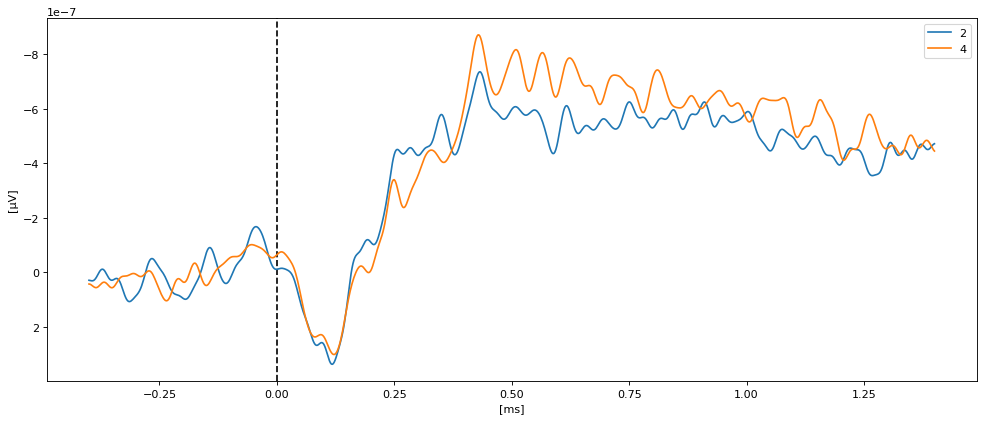

In [7]:
cda_all = dict()

for cond in cda_dict[list(cda_dict.keys())[0]].keys():
    cda_all[cond] = dict()

    for f in cda_dict.keys():
        
        perf = 'good'
        ldict = cda_dict[f][cond]['left']
        rdict = cda_dict[f][cond]['right']
        if (perf in ldict.keys() and len(ldict[perf])) and (perf in rdict.keys() and len(rdict[perf])):            
            cda_dict_cur = (cda_dict[f][cond]['left'][perf] + cda_dict[f][cond]['right'][perf])/2            
            cda_all[cond] = np.vstack([cda_all[cond], cda_dict_cur]) if len(cda_all[cond]) else cda_dict_cur
        else:
            print("==== SKIPPED: 0 points! (File: {} - Trigger: {})".format(str(f), str(t)))
        
plt.figure(figsize=(15, 6), dpi=80)
plt.axvline(x=0, color='k', linestyle='--')
plt.plot(times, cda_all['2'].mean(0), label='2')
plt.plot(times, cda_all['4'].mean(0), label='4')
plt.legend()
plt.gca().invert_yaxis()
plt.ylabel('[μV]')
plt.xlabel('[ms]')
#plt.savefig("./img/Villena-Gonzalez-2019_CDA-reprod.jpg", dpi=300)

## Plot Clean

Text(0.5, 0, '[ms]')

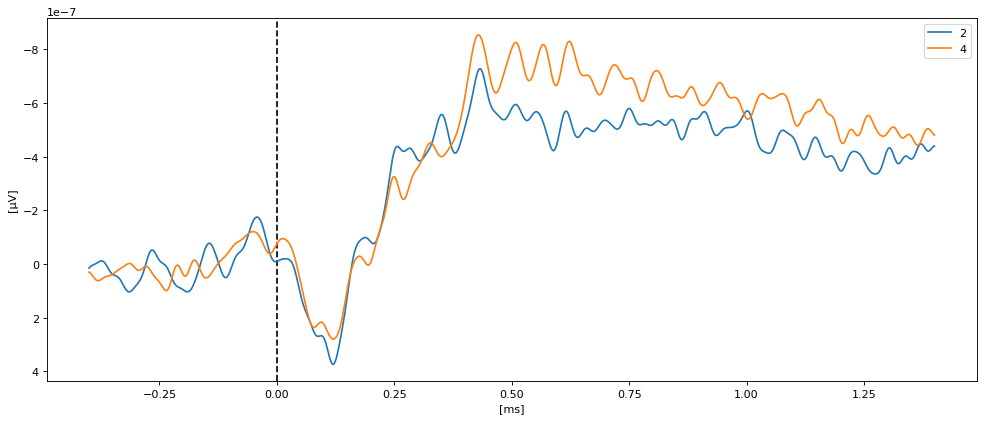

In [6]:
cda_all = dict()

for cond in cda_dict_clean[list(cda_dict.keys())[0]].keys():
    cda_all[cond] = dict()

    for f in cda_dict_clean.keys():
        
        perf = 'good'
        ldict = cda_dict_clean[f][cond]['left']
        rdict = cda_dict_clean[f][cond]['right']
        if (perf in ldict.keys() and len(ldict[perf])) and (perf in rdict.keys() and len(rdict[perf])):            
            cda_dict_cur = (cda_dict_clean[f][cond]['left'][perf] + cda_dict_clean[f][cond]['right'][perf])/2            
            cda_all[cond] = np.vstack([cda_all[cond], cda_dict_cur]) if len(cda_all[cond]) else cda_dict_cur
        else:
            print("==== SKIPPED: 0 points! (File: {} - Trigger: {})".format(str(f), str(t)))
        
plt.figure(figsize=(15, 6), dpi=80)
plt.axvline(x=0, color='k', linestyle='--')
plt.plot(times, cda_all['2'].mean(0), label='2')
plt.plot(times, cda_all['4'].mean(0), label='4')
plt.legend()
plt.gca().invert_yaxis()
plt.ylabel('[μV]')
plt.xlabel('[ms]')
#plt.savefig("./img/Villena-Gonzalez-2019_CDA-reprod.jpg", dpi=300)